# Semantic Segmentation of Satellite Images

The data comes from the ISPRS Potsdam dataset (https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-potsdam/).

The aim is to classify the images at pixel level according to 4 classes: Roads, Buildings, Vegetation and Other. We consider having 80% of the dataset for training and 20% for evaluation.

A UNet architecture is trained to segment the different classes while being evaluated using IoU, the final metrics are calculates from the obtained predictions.


# Import and seeds

In [ ]:
import colorsys
import itertools
import os
import sys
from glob import glob
from os.path import join
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
from google.colab import drive
from sklearn.metrics import confusion_matrix, jaccard_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.transforms.functional as TF

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(7)
torch.backends.cudnn.deterministic = True

# Google Colab initialization

In [ ]:
drive.mount('/content/gdrive')
TD_DIR = 'gdrive/My Drive/Datasets/Projet IOGS'
sys.path.append(TD_DIR)
print(os.path.exists(TD_DIR))

# Initialization of global variables


In [ ]:
DATA_FOLDER = "./Potsdam/30cm"  # ou sont les données
BATCH_SIZE = 2
N_CLASSES = 4
WINDOW_SIZE = 256
OVERLAP = 0
LENGTH_EPOCH = 100
DEVICE = "cpu"

# Dataloader definition

In [ ]:
def get_random_pos(img, window_shape):
    W, H = img.shape[-2:]
    x1 = np.random.randint(0, W - window_shape - 1)
    x2 = x1 + window_shape
    y1 = np.random.randint(0, H - window_shape - 1)
    y2 = y1 + window_shape
    return x1, x2, y1, y2

class Potsdam_train_dataset(torch.utils.data.Dataset):
    def __init__(self, img_files, cache=False,):
        super(Potsdam_train_dataset, self).__init__()

        self.cache = cache

        # List of files
        self.img_files = img_files
        self.gt_files = [i.replace("imgss", "gtss") for i in self.img_files]
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}

    def __len__(self):
        return LENGTH_EPOCH

    def data_augmentation(self, img, gt):
        #TODO ...
        return img, gt

    def __getitem__(self, i):
        # Pick a random image
        random_idx = np.random.randint(0, len(self.img_files) - 1)

        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys() and random_idx in self.label_cache_.keys():
            data = self.data_cache_[random_idx]
            label = self.label_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * cv.imread(self.img_files[random_idx])[..., ::-1].transpose((2, 0, 1)) # OpenCV reads imags in BGR
            label = cv.imread(self.gt_files[random_idx], 0)
            if self.cache:
                self.data_cache_[random_idx] = data
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]

        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return torch.from_numpy(data_p), torch.from_numpy(label_p)

# Visualization functions

In [ ]:
def visualize(image, target):
  colors = random_colors(N_CLASSES)
  plt.figure(figsize=(20,20))
  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.subplot(1,2,2)
  plt.imshow(apply_mask(image, target, colors))
  plt.show()

def random_colors(n, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n, 1, brightness) for i in range(n)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    np.random.shuffle(colors)
    return colors


def apply_mask(image, mask, colors, alpha=0.5):
    """Apply the given mask to the image. Binary mask.
    """
    target = image.copy()
    for i, color in enumerate(colors):
      for c in range(3):
          target[:, :, c][mask == i] =  image[:, :, c][mask == i] * (1 - alpha) + alpha * color[c]
    return target

# Metrics

Intersection over Union (IoU) is used (also called Jaccard Index: https://en.wikipedia.org/wiki/Jaccard_index) to evaluate performance.

In [ ]:
def iou_from_matrix(matrix):
    TP = np.diag(matrix)
    FN = np.sum(matrix,1) - TP
    FP = np.sum(matrix,0) - TP
    return TP/(TP+FN+FP)

def get_metrics(target, pred):
  pred = pred.flatten()
  target = target.flatten()
  confusion = confusion_matrix(target, pred)
  # iou = jaccard_score(target, pred, labels=np.arange(N_CLASSES), average=None)  # Much slower
  iou = iou_from_matrix(confusion)
  return confusion, iou

# Data train/test split

In [ ]:
img_files = glob(join(TD_DIR, DATA_FOLDER, "imgs", '*.tif'))
train_imgs, test_imgs = train_test_split(img_files, test_size=0.2, random_state=42)

# Visualization

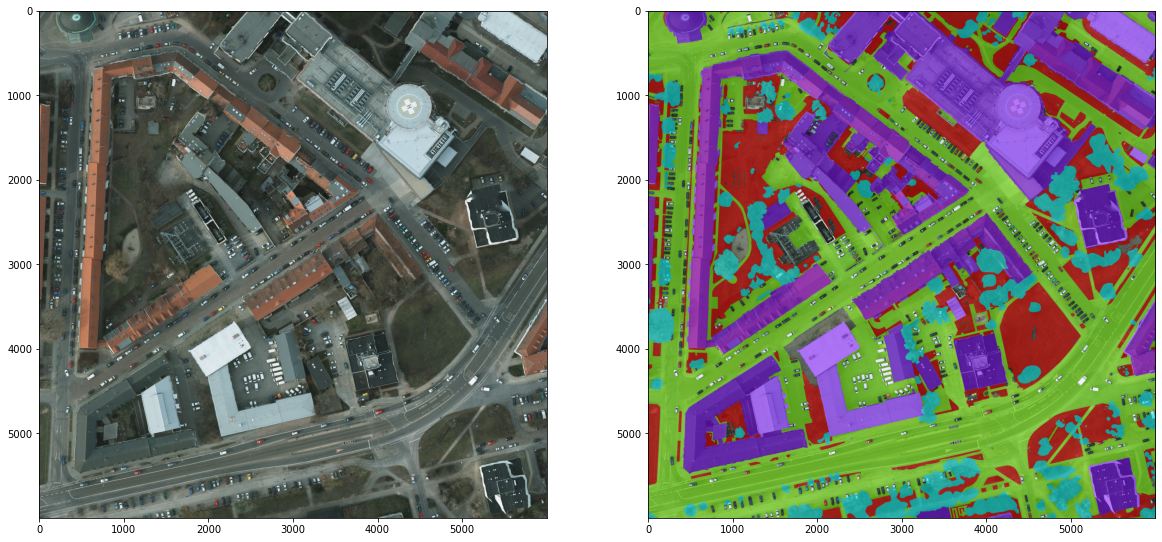

IoU and mean IoU:  [1. 1. 1. 1. 1. 1.] 1.0


In [ ]:
image = cv.imread(train_imgs[0])[..., ::-1] / 255
target = cv.imread(train_imgs[0].replace("imgs", "gts"), 0)
visualize(image, target)
_, iou = get_metrics(target, target)
print("IoU and mean IoU: ", iou, np.mean(iou))

# UNet Architecture

In [ ]:
""" Parts of the U-Net model """
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class Net(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Net, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
Normal
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
from torchsummary import summary
model= Net(n_channels=3,n_classes=4)
model.to(DEVICE)
summary = summary(model, (3,64,64)) #input_size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,864
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
        DoubleConv-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,728
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]         147,456
      BatchNorm2d-13          [-1, 128, 32, 32]             256
             ReLU-14          [-1, 128,

# Test function definition

In [ ]:
def sliding_window(image, overlap=0, window_size=WINDOW_SIZE):
    """ Slide a window_shape window across the image with an overlap between 0 and 1 """
    assert overlap >= 0 and overlap < 1
    shape_img = image.shape[1]
    step = int((1-overlap) * window_size)
    for x in range(0, shape_img, step):
        if x + window_size > shape_img:
            x = shape_img - window_size
        for y in range(0, shape_img, step):
            if y + window_size > shape_img:
                y = shape_img - window_size
            yield x, y, window_size

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def from_coord_to_patch(img, coords):
    """Returns patches of the input image. coors is an output of grouper(n, sliding window(...))"""
    image_patches = [img[:, x : x + w, y : y + w] for x, y, w in coords]
    image_patches = torch.stack(image_patches).float()
    return image_patches

def test(net, test_imgs=test_imgs):
    with torch.no_grad():
        totalpred=[]
        totaltarget=[]
        for test_img_file in tqdm(test_imgs, total=len(test_imgs)):
            img = torch.from_numpy(cv.imread(test_img_file)[..., ::-1].transpose((2, 0, 1)) / 255).to(DEVICE)
            target = cv.imread(test_img_file.replace("imgs", "gts"), 0)
            pred = np.zeros(img.shape[1:] + (N_CLASSES,))
            for coords in grouper(BATCH_SIZE, sliding_window(img, overlap=OVERLAP, window_size=WINDOW_SIZE)):
                data_patches = from_coord_to_patch(img, coords)
                outs = net(data_patches).data.cpu().numpy()

                for out, (x, y, w) in zip(outs, coords):
                    out = out.transpose((1, 2, 0))
                    pred[x : x + w, y : y + w] += out
            pred = np.argmax(pred, axis=-1)
            totalpred.append(pred)
            totaltarget.append(target)
        return totalpred,totaltarget

# Training loop

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#using gradient descent as a backpropagation algorithm for optimzation
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

from numpy.core.fromnumeric import shape
import cv2
train_dataset = Potsdam_train_dataset(train_imgs)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

t_loss = []
t_accuracy = []

for epoch in range(1):  # loop over the dataset multiple times (number of epochs)
    print("Epoch: ",epoch)running_loss
    running_loss = 0.0
    for data in tqdm(trainloader, total=LENGTH_EPOCH // BATCH_SIZE):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #convert them to tensor so we can apply model to them
        inputs= torch.tensor(inputs)
        labels= torch.tensor(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        inputs=inputs.to(DEVICE).float()
        labels=labels.to(DEVICE).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        t_loss.append(loss.item())
        print("Loss:", loss.item())

    pred, target= test(model, test_imgs=test_imgs)
    pred=np.asarray(pred)
    target=np.asarray(target)
    confusion, iou= get_metrics(target, pred)
    accuracy= iou_from_matrix(confusion)
    t_accuracy.append(np.mean(accuracy))

In [ ]:
import seaborn as sns

pred, target= test(model, test_imgs=test_imgs)
pred=np.asarray(pred)
target=np.asarray(target)
#confusion matrix
confusion, iou= get_metrics(target, pred)
target_names=[0,1,2,3]
#Doing some tricks using seaborn library to plot confusion matrix in a representative way
cmn = confusion.astype('float') /confusion.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cmn, annot=True, fmt='.2f',xticklabels=target_names,yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
#calling function that returns accuracy metric
accuracy= iou_from_matrix(confusion)
print("accuracy:","{:.2f}".format(np.mean(accuracy)))

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
image = cv.imread(test_imgs[2])[..., ::-1] / 255
plt.imshow(image)
#plt.imshow(target[2])
plt.title('True image (RGB)')
plt.subplot(2,2,2)
plt.imshow(pred[2])
plt.title('Predicted image')
plt.show()

In [ ]:
plt.figure
plt.plot(range(len(t_accuracy)), t_accuracy)
plt.show()

In [ ]:
from IPython.core.display import Image
plt.figure
image = pred[2]
plt.imshow(TF.hflip(image))
plt.show()